In [3]:
from semantic_comms import calculate_psnr, train_semantic_communication_system, load_images, add_awgn_noise
import torch
import numpy as np
from semantic_models.sc1 import SemanticEncoder, SemanticDecoder
import matplotlib.pyplot as plt

In [6]:
from semantic_extractor import SemanticBased
import os

folder_path = "output/original"
image_name = os.listdir(folder_path)[0]


semantic_images = SemanticBased(image_name=image_name, image_path=os.path.join(folder_path, image_name))
semantic_images.extract_images(color_image=True)

0000.jpg


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [16]:
torch.manual_seed(42)
np.random.seed(42)

# Images
images = load_images("output/masks")
num_images = images.size(0)
image_channels = images.size(1)
image_height = images.size(2)
image_width = images.size(3)

# Reshape images tensor to fit the semantic encoder input shape
images = images.view(num_images, image_channels, image_height, image_width)

# Set the desired SNR and number of training epochs
snr = 12  # dB
num_epochs = 1500

# Train the semantic communication system
encoder_model = SemanticEncoder()
decoder_model = SemanticDecoder()

# encoder_model = SemanticEncoder2()
# decoder_model = SemanticDecoder2()

# encoder_model = SemanticEncoderTC()
# decoder_model = SemanticDecoderTC()

In [17]:
encoder, decoder = train_semantic_communication_system(encoder_model, decoder_model, images, snr, num_epochs)

Epoch: 10/1500, Loss: 0.4136052429676056
Epoch: 20/1500, Loss: 0.28468599915504456
Epoch: 30/1500, Loss: 0.19352425634860992
Epoch: 40/1500, Loss: 0.12652172148227692
Epoch: 50/1500, Loss: 0.07953385263681412
Epoch: 60/1500, Loss: 0.04785289242863655
Epoch: 70/1500, Loss: 0.027669094502925873
Epoch: 80/1500, Loss: 0.015450232662260532
Epoch: 90/1500, Loss: 0.008480524644255638
Epoch: 100/1500, Loss: 0.004732176195830107
Epoch: 110/1500, Loss: 0.0028258070815354586
Epoch: 120/1500, Loss: 0.0018971521640196443
Epoch: 130/1500, Loss: 0.0014354875311255455
Epoch: 140/1500, Loss: 0.0012007391778752208
Epoch: 150/1500, Loss: 0.0010605972493067384
Epoch: 160/1500, Loss: 0.0009585267398506403
Epoch: 170/1500, Loss: 0.0008743320940993726
Epoch: 180/1500, Loss: 0.0008002268150448799
Epoch: 190/1500, Loss: 0.0007349133375100791
Epoch: 200/1500, Loss: 0.0007060624775476754
Epoch: 210/1500, Loss: 0.0006230742437765002
Epoch: 220/1500, Loss: 0.0005745140369981527
Epoch: 230/1500, Loss: 0.00052970013

In [18]:

# Calculate SNR
encoder_images = encoder(images)
noisy_images = add_awgn_noise(encoder_images, snr)
restored_images = decoder(noisy_images)
theta = 1.0

psnr = calculate_psnr(images, restored_images, restored_images, theta)


print(images.shape)
print(encoder_images.shape)
print(restored_images.shape)
print(f"PSNR over AWGN channel: {psnr.item()} dB")

torch.Size([4, 3, 32, 32])
torch.Size([4, 32, 8, 8])
torch.Size([4, 3, 32, 32])
PSNR over AWGN channel: 28.646270751953125 dB


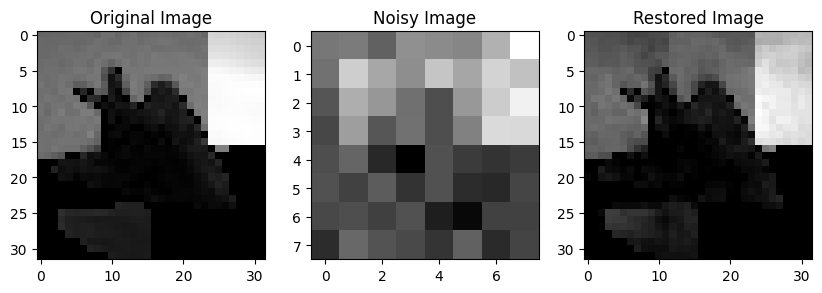

In [19]:
#plotting
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
im = images.detach().numpy()
im = np.sum(im, axis=0)
plt.imshow(im[0, :, :], cmap="gray")
plt.title("Original Image")
plt.subplot(1, 3, 2)
ns= noisy_images.detach().numpy()
ns = np.sum(ns, axis=0)
plt.imshow(ns[0, :, :], cmap="gray")
plt.title("Noisy Image")
plt.subplot(1, 3, 3)
rs= restored_images.detach().numpy()
#sum rs on axis 0 and 1
rs = np.sum(rs, axis=0)
plt.imshow(rs[0, :, :], cmap="gray")
plt.title("Restored Image")
plt.show()

In [20]:
import requests

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)


In [29]:
from compressai.zoo import cheng2020_anchor

model = cheng2020_anchor(quality=6, pretrained=True).eval()

#download a sample image
import imageio
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import requests
#download a sample image
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")
image = resize(image, (256, 256), anti_aliasing=True)

#convert to tensor
image = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)

#compress and decompress
compressed_image = model.compress(image)

#decompress
reconstructed_image = model.decompress(compressed_image["strings"], compressed_image["shape"])

/tmp/ipykernel_38186/656525534.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")


In [26]:
recon = reconstructed_image['x_hat'].squeeze(0).permute(1, 2, 0).detach().numpy()
im  = image.squeeze(0).permute(1, 2, 0).detach().numpy()

In [27]:
psnr = psnr(im, recon)

In [28]:
print(f"PSNR: {psnr} dB")

PSNR: 30.471833165082515 dB
